## California Housing Prices

Este *dataset* contiene los precios medios de las viviendas en los distritos de California derivados del censo de 1990.

## Objetivo

Se tratarán dos modelos de Machine Learning sobre este dataset.

- Modelo predictor regresor del precio de las casas.
- Modelo de clusterización no supervisada.

## Referencia

Este dataset es un versión modificada del [Repositorio de StatLib](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html), disponible para su descarga en [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices?select=housing.csv).

## Librerías

In [1]:
import pickle
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, OrdinalEncoder,
                                   PowerTransformer)
from sklearn.svm import SVR
from xgboost import XGBRegressor

from utils.datascience import get_cardinality, regression_report
from utils.vizdatatools import (plot_categorical_numerical_relationship,
                                plot_multiple_categorical_distributions,
                                plot_multiple_histograms_KDEs_boxplots)


## Vistazo técnico (y rápido de los datos)

En la documentación de este *dataset* encontramos la siguiente información:

1. longitude: Una medida de qué tan al oeste está una casa; un valor más alto indica más al oeste.
2. latitude: Una medida de qué tan al norte está una casa; un valor más alto indica más al norte.
3. housing_median_age: Mediana de la edad de una casa dentro de un bloque; un número más bajo indica un edificio más nuevo.
4. total_rooms: Número total de habitaciones dentro de un bloque.
5. total_bedrooms: Número total de dormitorios dentro de un bloque.
6. population: Número total de personas que residen dentro de un bloque.
7. households: Número total de unidades familiares, un grupo de personas que residen dentro de una unidad de vivienda, para un bloque.
8. median_income: Mediana del ingreso de la unidad familiar dentro de un bloque de casas (medido en decenas de miles de dólares estadounidenses).
9. median_house_value: Mediana del valor de la vivienda para los hogares dentro de un bloque (medido en dólares estadounidenses).
10. ocean_proximity: Ubicación de la casa con respecto al océano/mar.

In [2]:
df_housing = pd.read_csv('./data/california_housing_prices.csv')
df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Machine Learning Supervisado: Regresor

Vamos a comenzar la parte de Machine Leaning Supervisado: `Predicción del precio de las casas`.

El *target* de este problema de mercado es "median_house_value". Y como no hay ninguna otra indicación de "negocio" vamos a querer optimizar el RMSE (*Root Mean Squared Error*), porque penaliza de manera más fuerte los errores grandes en comparación con otras métricas, y se expresa en las mismas unidades que la variable objetivo.



### Split de train y test

Para ello lo primero que hacemos es el split de *train* y *test* de forma que no se contaminen los datos o realicemos sesgos.


In [4]:
# Split de train y test
random_state = 123
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# ¡Cuidado! Porque un random_state = 42 hace que no haya ningún valor missing en el train

### Mini-EDA

Para el problema de regresión numérica el *target* claramente es "median_house_value".

In [5]:
# Información general del dataset
get_cardinality(train_set)

pandas.DataFrame shape:  (16512, 10)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
longitude,825,4.996366,0,0.0,float64,Numeric - Discrete
latitude,840,5.087209,0,0.0,float64,Numeric - Discrete
housing_median_age,52,0.314922,0,0.0,float64,Numeric - Discrete
total_rooms,5509,33.363614,0,0.0,float64,Numeric - Continuous
total_bedrooms,1823,11.040455,172,1.041667,float64,Numeric - Discrete
population,3675,22.256541,0,0.0,float64,Numeric - Discrete
households,1721,10.422723,0,0.0,float64,Numeric - Discrete
median_income,10953,66.333576,0,0.0,float64,Numeric - Continuous
median_house_value,3663,22.183866,0,0.0,float64,Numeric - Discrete
ocean_proximity,5,0.030281,0,0.0,object,Categoric


In [6]:
# Análisis de dispersión
train_set.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,16512.000000,16512.000000,16512.000000,16512.000000,16340.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7329
mean,-119.566976,35.627757,28.570918,2648.943193,541.041493,1434.115734,502.672844,3.870716,206968.729530,NaN
std,2.000519,2.134543,12.582281,2208.372267,427.316722,1130.309986,387.541495,1.900132,115414.844601,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1453.000000,297.000000,789.000000,280.000000,2.562500,119400.000000,NaN
50%,-118.490000,34.250000,29.000000,2138.500000,438.000000,1170.000000,412.000000,3.529400,180400.000000,NaN
75%,-118.010000,37.710000,37.000000,3158.000000,650.000000,1735.000000,608.000000,4.750375,264725.000000,NaN


También puede ser interesante crear nuevas variables numéricas con mayor explicabilidad.


In [7]:
# Crear nuevas features más descriptivas
train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set["people_per_house"] = train_set["population"] / train_set["households"]

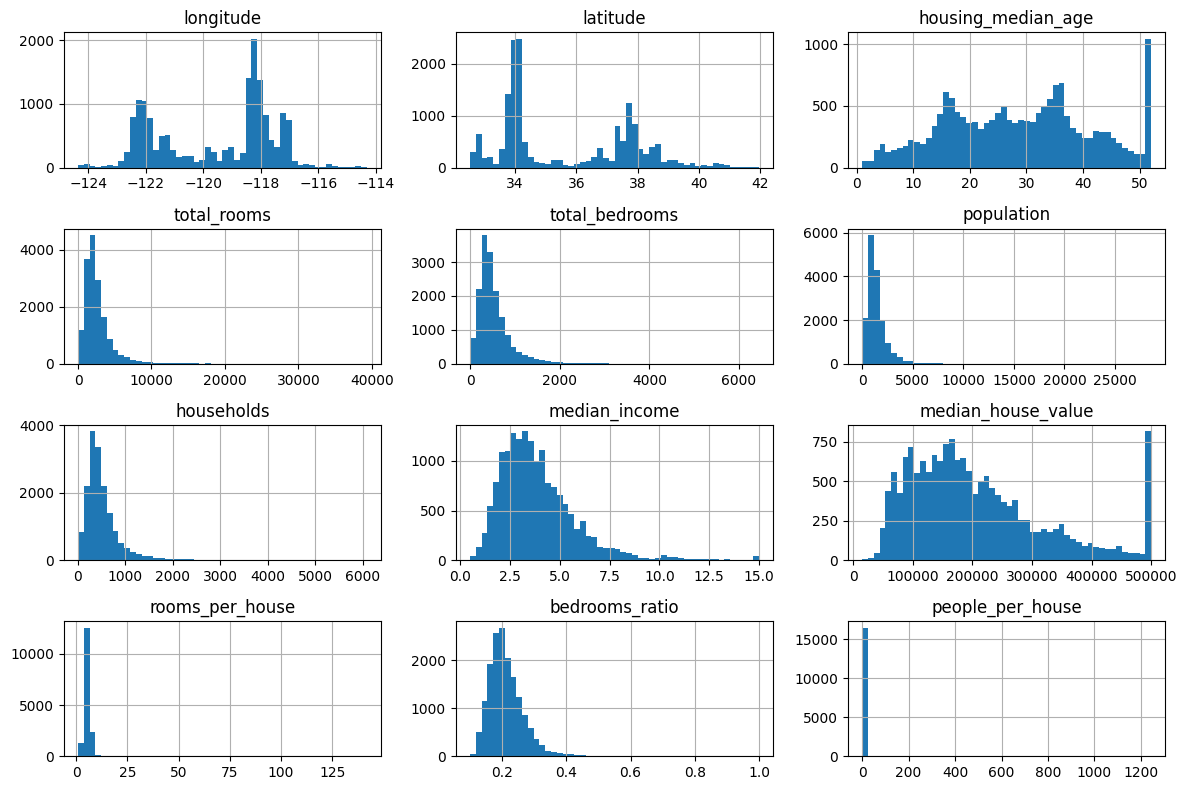

In [8]:
# Análisis de distribuciones
train_set.hist(bins=50, figsize=(12, 8)); 
plt.tight_layout()
plt.show()

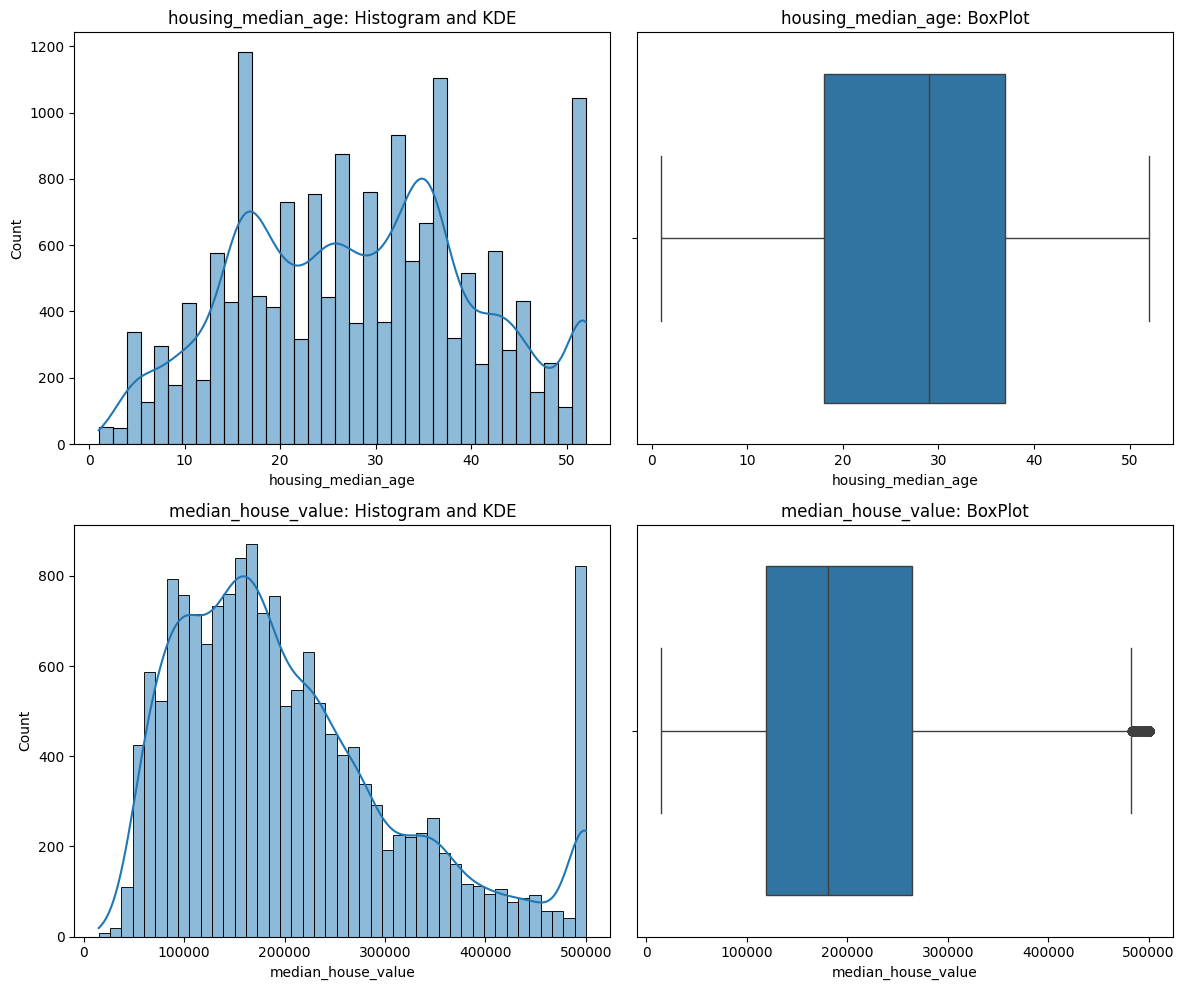

In [9]:
# Observar mejor esos valores extremos / capados
plot_multiple_histograms_KDEs_boxplots(train_set, ['housing_median_age', 'median_house_value'])

El *target* no tiene una forma Gaussiana perfecta, aunque es bastante bueno. De todas formas vamos a probar a aplicar transformaciones no lineales para mejorarlo, como son: el logaritmo, o como veremos más adelante un *PowerTransformer* de sklearn.

<Axes: >

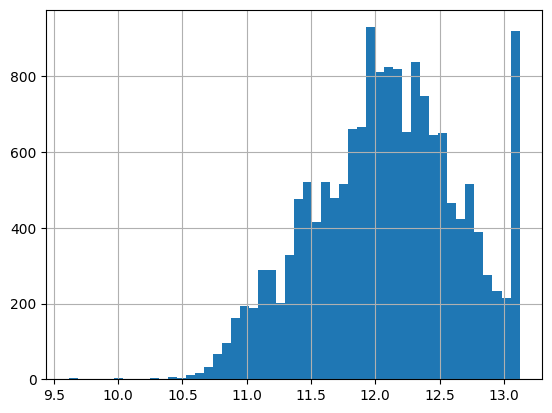

In [10]:
# Aplicar logaritmo sobre el target para mejorar su forma Gaussiana
np.log(train_set['median_house_value']).hist(bins=50)

Vamos a analizar un poco en detalle los valores extremos del data set, porque parecen estar acotados lagunos y otros no tienen demasiado sentido.

In [11]:
train_set['housing_median_age'].value_counts().sort_index(ascending=False).head()

housing_median_age
52.0    1006
51.0      38
50.0     111
49.0     110
48.0     134
Name: count, dtype: int64

In [12]:
train_set['median_house_value'].value_counts().sort_index(ascending=False).head()

median_house_value
500001.0    766
500000.0     22
499100.0      1
499000.0      1
498800.0      1
Name: count, dtype: int64

In [13]:
train_set['rooms_per_house'].value_counts().sort_index(ascending=False).head()

rooms_per_house
141.909091    1
132.533333    1
62.422222     1
59.875000     1
56.269231     1
Name: count, dtype: int64

In [14]:
train_set['bedrooms_ratio'].value_counts().sort_index(ascending=False).head()

bedrooms_ratio
1.000000    3
0.923077    1
0.922414    1
0.896552    1
0.780347    1
Name: count, dtype: int64

In [15]:
train_set['people_per_house'].value_counts().sort_index(ascending=False).head()

people_per_house
1243.333333    1
502.461538     1
230.172414     1
83.171429      1
51.400000      1
Name: count, dtype: int64

Conclusiones del mini-EDA

- Existen variables donde se han "capado" (puesto límite artificial) como "median_house_value" (*target*) y "housing_median_age". Esto puede ser un problema porque el modelo puede aprender que no debe dar valores por encima de estos, pero para este ejemplo y sin la supervisión de "negocio", seguiremos trabajando con estos datos.

- Hay muchas distribuciones tipo No-Gaussianas, desplazadas a la izquierda y con aparente larga cola. Normalizaremos los datos para que los modelos dependientes de ello funcionen mejor. --> `El método PowerTransformer convierte los datos a una forma más Gaussina. Pero cuidado, porque con "longitude" no va a funcionar bien ya que todos los valores son negativos, aunque no me importa porque voy a eliminar esta feature.`

- Se ve que las escalas (ejes x) son muy diferentes como ya habíamos observado en el análisis de varianza. Habrá que estandarizar o normalizar los datos para beneficiar a los modelos (que lo necesiten). 

- "people_per_house" no parece tener mucho sentido. Son números demasiado altos para una única casa. Lo eliminaremos.

Vamos a comprobar el efecto que tendría aplicar una *power transform* de sklearn sobre las features numéricas. Que además se encargará de estandarizar los datos.

Pero cuidado con el método "yeo-johnson" porque no trabaja bien con solo datos negativos, así que no nos fiemos de la *feature* "longitude".

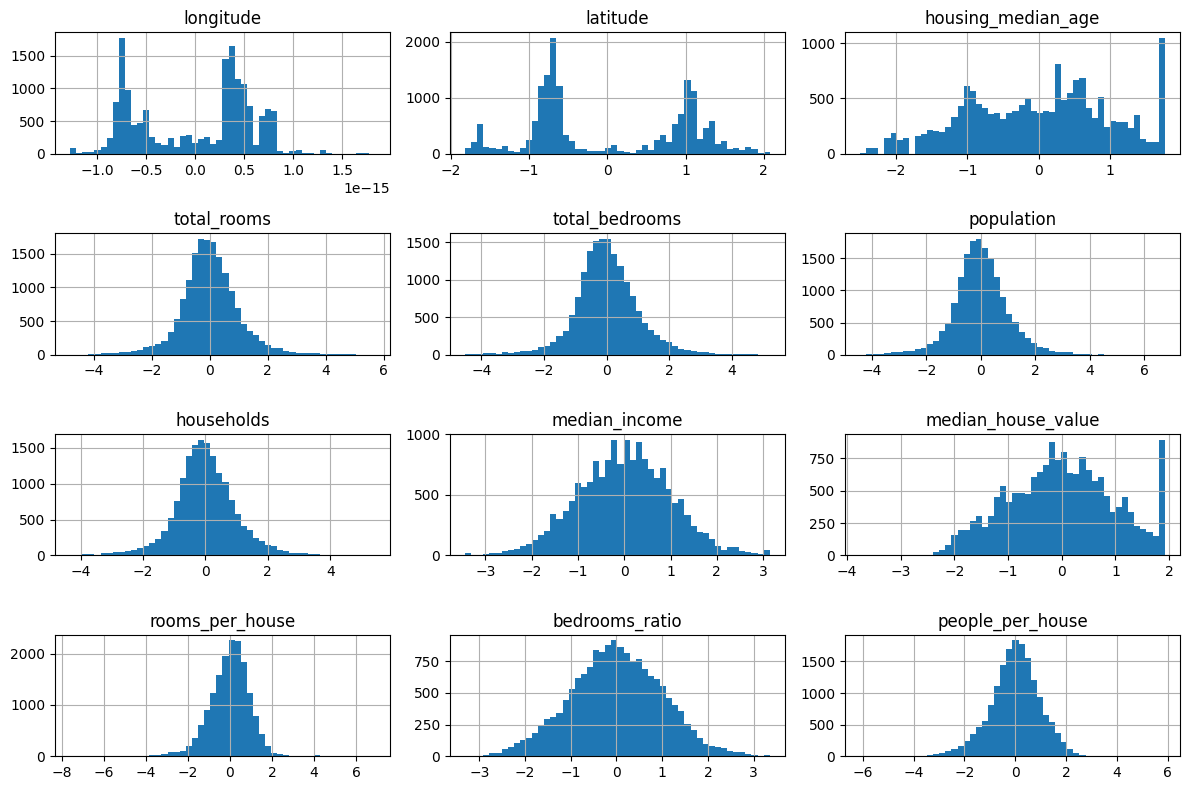

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ratio,people_per_house
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.634000e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.634000e+04,1.651200e+04
mean,5.434458e-18,-3.445125e-08,-8.651564e-16,8.523006e-17,-2.351444e-16,-5.225686e-16,-2.411400e-16,2.619029e-16,6.395616e-16,1.485999e-15,8.282780e-16,-1.270517e-15
std,5.905617e-16,1.000030e+00,1.000030e+00,1.000030e+00,1.000031e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000031e+00,1.000030e+00
min,-1.276756e-15,-1.821388e+00,-2.503796e+00,-4.811197e+00,-4.517715e+00,-4.440702e+00,-4.334153e+00,-3.438050e+00,-3.754716e+00,-7.595083e+00,-3.309210e+00,-6.109119e+00
25%,-6.383782e-16,-7.751048e-01,-8.139919e-01,-5.482285e-01,-5.719500e-01,-5.679996e-01,-5.665066e-01,-6.698938e-01,-7.147138e-01,-5.690268e-01,-6.650468e-01,-5.778652e-01
50%,3.053113e-16,-5.703418e-01,7.939042e-02,-3.336923e-02,-4.276685e-02,-3.556351e-02,-3.781253e-02,1.814417e-02,-5.786945e-03,6.686015e-02,-9.638451e-03,2.807109e-02
75%,4.718448e-16,1.035223e+00,6.871255e-01,5.333855e-01,5.443738e-01,5.495961e-01,5.479597e-01,6.703857e-01,6.880215e-01,6.051447e-01,6.863678e-01,6.140216e-01
max,1.831868e-15,2.077475e+00,1.762902e+00,5.686407e+00,5.201139e+00,6.758068e+00,5.423247e+00,3.142670e+00,1.917549e+00,6.882273e+00,3.349748e+00,5.882037e+00


In [16]:
# PowerTranform. CUIDADO: Porque con "longitude" no va a funcionar bien ya que todos los valores son negativos
pt = PowerTransformer(method='yeo-johnson', standardize=True)

train_num = train_set.select_dtypes(include='number')
train_num = pd.DataFrame(pt.fit_transform(train_num), columns=train_num.columns)
train_num.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

train_num.describe()


PowerTransformer no solo modifica la distribución a una Gaussiana, sino que además estandariza los datos, así que es perfecto para procesamiento en el que estamos interesados.

In [17]:
# Eliminar valores de "housing_median_age" mayores a 51,
# y valores de "median_house_value" mayores a 500000.0
# train_set = train_set[(train_set['housing_median_age'] < train_set['housing_median_age'].max())
#                       & (train_set['median_house_value'] < train_set['median_house_value'].max() )
#                       ]

# Eliminar valores de "housing_median_age" mayores a 50
# train_set = train_set[train_set['housing_median_age'] < train_set['housing_median_age'].max()]

Aparentemente solo hay una variable categórica: *ocean_proximity*. Aunque un poco más adelante veremos que conviene crear una más.


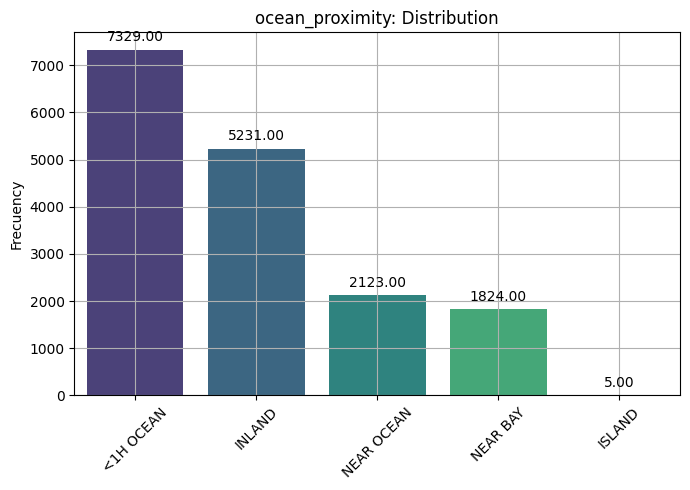

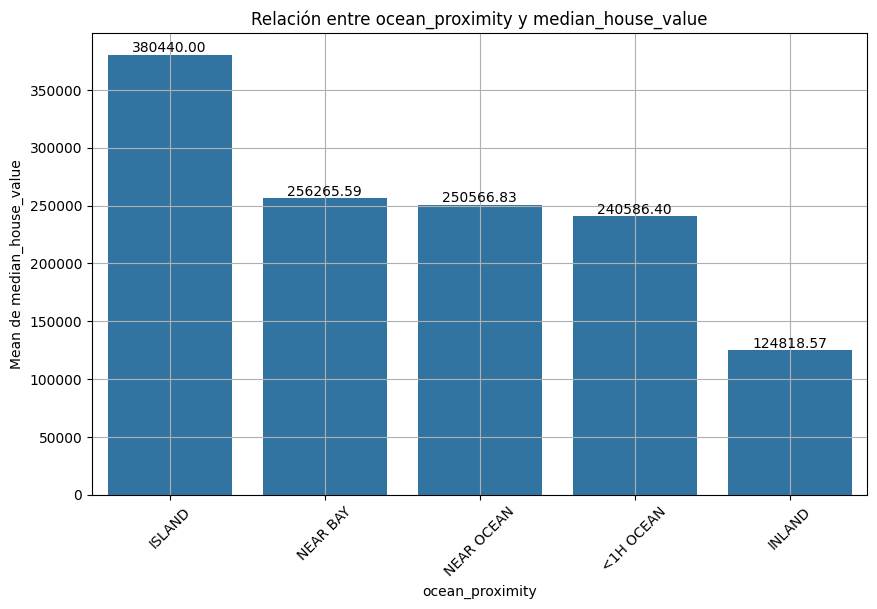

In [18]:
# Análisis de las variables categóricas
plot_multiple_categorical_distributions(train_set, ['ocean_proximity'], relative=False)
plot_categorical_numerical_relationship(train_set, 'ocean_proximity', 'median_house_value')

Parece interesante convertir "median_income" en una variable categórica, porque ya de por sí viene de una mediana. Vamos a recurrir a la función `cut` de pandas para ello.

`SPOILER`: en realidad, los resultados mejorar si "median_income" se conserva como una feature numérica, pero como este es un ejemplo académico para el uso de Pipelines, vamos a trasnformar esta variable en categórica de forma que aumentemos ligeramente la complejidad.

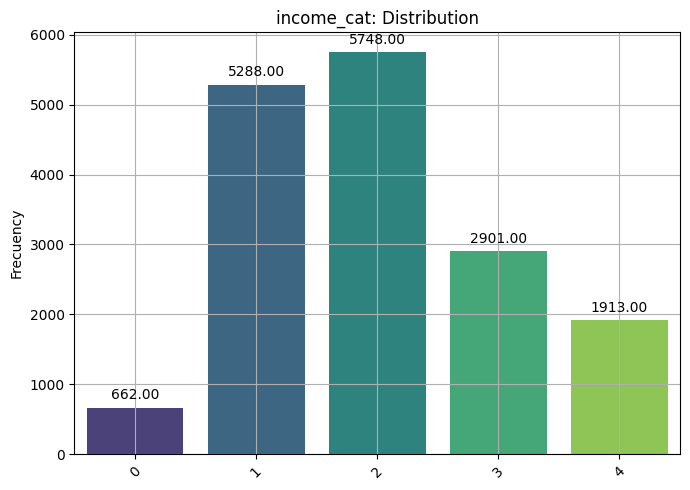

c:\Users\Lander\Documents\GitHub\pipelines_team_challenge\california_housing_prices\src\utils\vizdatatools.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(categorical_col)[numerical_col].mean()


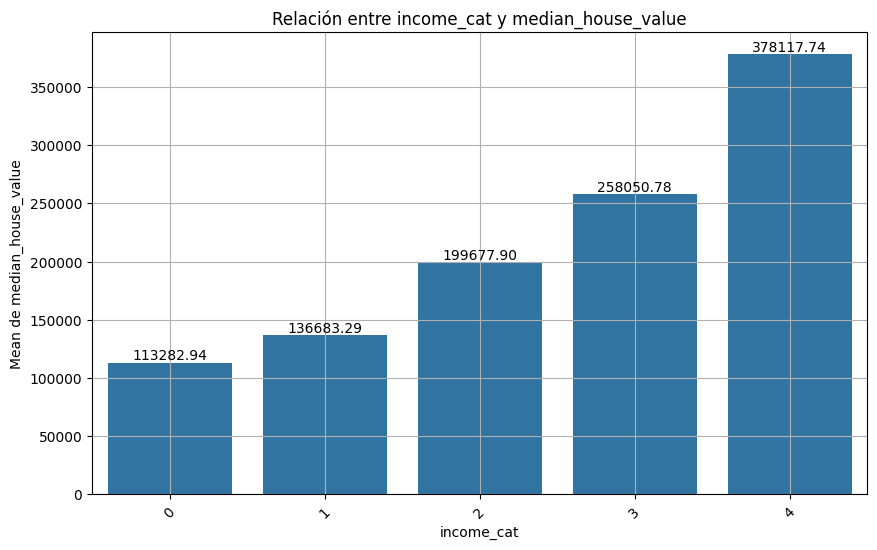

In [19]:
# Convertir "median_income" en una nueva variable categórica
train_set['income_cat'] = pd.cut(train_set['median_income'],
                                 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                 labels=[0, 1, 2, 3, 4]
                                 )

plot_multiple_categorical_distributions(train_set, ['income_cat'], relative=False)
plot_categorical_numerical_relationship(train_set, 'income_cat', 'median_house_value')

Analicemos las correlación con el *target*.

In [20]:
# Correlación de las features numéricas con el target
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688904
rooms_per_house       0.150165
total_rooms           0.132965
housing_median_age    0.099487
households            0.064043
total_bedrooms        0.048823
people_per_house     -0.019762
population           -0.024484
longitude            -0.038349
latitude             -0.150574
bedrooms_ratio       -0.255369
Name: median_house_value, dtype: float64

Por la baja correlación con el *target* de: total_bedrooms y people_per_house, estas son variables que no vamos a usar para el modelo. Sería intersanete ver la colinealidad entre features para no tener información redundante, pero aquí no lo vamos a mirar.

### Tratamiento de features, modelado y entranamiento con Pipelines.

El tratammiento de features se va a hacer mediante Pipelines de scikit-learn.

Con el escueto mini-EDA, y como conocemos ya un poco el dataset de haberlo trabajado anteriormente, estas son las transformaciones que vamos a realizar en el "train_set", y después en el "test_set". Todo ello se va a hacer a través de Pipelines.

- Cargar de nuevo los datos y hacer un split de train y test.
- Definir el *target* = *median_house_value*.
- Crear nuevas features más significativas y sencillas de comprender: *income_cat*, *rooms_per_house*, *bedrooms_ratio*.
- Definir las variables numéricas, las categóricas, y eliminar las poco representativas.
- Imputar valores missings. La mediana para las features numéricas y la moda para las categóricas. (Si se prefiere, se puede descomentar una línea de código para eliminar todos los valores missings, porque en realidad hay datos suficientes e igual no merece la pena pelearse en cómo rellenarlos).
- Tranformar la distribución de las features numéricas para que tengan un distribución más Gaussina y estandarizar los datos.
- Aplicar un OrdinalEncoder() sobre *ocean_proximity*.
- Aunque el *target* tiene una distribución bastante adecuada, vamos a aplicar un *PowerTransformer* para que sea algo más Gaussina, haciendo uso del estimador *TransformedTargetRegressor*.

In [21]:
# Cargar dataset original
df_housing = pd.read_csv('./data/california_housing_prices.csv')

# Dividir el conjunto de datos
target = 'median_house_value'
random_state = 123
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Eliminar valores NaN si no queremos imputar media, mediana, moda... Por sencillez
# train_set.dropna(inplace=True)
# test_set.dropna(inplace=True)

X_train = train_set.drop(columns=[target]) 
y_train = train_set[target]
X_test = test_set.drop(columns=[target]) 
y_test = test_set[target] 

# Definir features numéricas, categóricas, y las que queremos eliminar
feats_cat = ['ocean_proximity', 'income_cat']
feats_num = ['latitude', 'housing_median_age', 'population', 'households', 'rooms_per_house', 'bedrooms_ratio']
feats_to_exclude = [feat for feat in X_train.columns if feat not in (feats_cat + feats_num)]



In [22]:
def create_extra_features(X):
    """
    Crea features nuevas para el dataset, con mayor explicabilidad que las del dataframe original.
    """
    X = X.copy()
    X['rooms_per_house'] = X['total_rooms'] / X['households']
    X['bedrooms_ratio'] = X['total_bedrooms'] / X['total_rooms']
    X['income_cat'] = pd.cut(X['median_income'],
                             bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                             labels=[0, 1, 2, 3, 4])
    return X

In [23]:
# Pipeline para crear nuevas features con mayor explicabilidad. Retorna un DataFrame
pipeline_create_features = Pipeline(steps=[
    ('features_creator', FunctionTransformer(create_extra_features, validate=False))
    ])

# Pipeline para features numéricas. Imputa la mediana (sobre valores missing), transforma los datos en más gaussianos, y estandariza.
pipeline_num = Pipeline([
    ('median_imputer', SimpleImputer(strategy='median')),
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

# Imputa la moda sobre features categóricas
pipeline_cat = Pipeline([
    ('mode_imputer', SimpleImputer(strategy='most_frequent'))
    ])

# Pipeline para hacer Ordinal Encoding sobre la feature: "ocean_proximity". Con un orden pre-escogido.
pipeline_oh = Pipeline([
    ('mode_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=[['INLAND', '<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND']],
                                       handle_unknown='use_encoded_value',
                                       unknown_value=-1))  
    ])

# Crear el preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer([
    ('exclude', 'drop', feats_to_exclude),
    ('process_num', pipeline_num, feats_num),
    ('process_cat', pipeline_cat, ['income_cat']),
    ('ord_encoder', pipeline_oh, ['ocean_proximity'])
    ],
    remainder='passthrough'
)

El siguiente apartado es solo para comprobar visualmente todas las transformaciones que se han implementado en el Pipeline.

In [24]:
# Ejemplo para ver los pasos internos de los Pipelines. 
# No hace falta ejecutarlo, aunque ayuda en la comprensión de los Pipelines.
show_steps = True

if show_steps:
    print('All intermediate steps will be displayed.')
    
    print('\nnOriginal X_train and y_train:')
    print(X_train.shape, y_train.shape,sep='\n')
    display(X_train.head())
    display(y_train.head())
    display(X_train.info())

    # Aplicar "pipeline_drop_create_feats"
    X_train_tmp = pipeline_create_features.fit_transform(X_train)
    print('\nnX_train with new features:')
    print(X_train_tmp.shape)
    display(X_train_tmp.head())
    
    print('\nfeats_to_exclude:')
    print(feats_to_exclude)
    
    # Esto es exactamente lo mismo que hacer el siguiente paso
    # Aplicar el "preprocessor" sobre el "pipeline_drop_create_feats"
    print('\nApplying the "preprocessor" on "pipeline_drop_create_feats".')
    X_train_tmp = pipeline_create_features.fit_transform(X_train)
    X_train_tmp = pd.DataFrame(preprocessor.fit_transform(X_train_tmp),
                               columns=preprocessor.get_feature_names_out()
                               )
    print(X_train_tmp.shape)
    display(X_train_tmp.head())
    display(X_train_tmp.info())
    display(X_train_tmp.describe(include='all'))

Se van a mostrar todos los pasos intermedios.

X_train e y_train originales:
(16512, 9)
(16512,)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
9950,-122.33,38.38,28.0,1020.0,169.0,504.0,164.0,4.5694,INLAND
3547,-118.60,34.26,18.0,6154.0,1070.0,3010.0,1034.0,5.6392,<1H OCEAN
4448,-118.21,34.07,47.0,1346.0,383.0,1452.0,371.0,1.7292,<1H OCEAN
6984,-118.02,33.96,36.0,2071.0,398.0,988.0,404.0,4.6226,<1H OCEAN
4432,-118.20,34.08,49.0,1320.0,309.0,1405.0,328.0,2.4375,<1H OCEAN


9950    287500.0
3547    271500.0
4448    191700.0
6984    219700.0
4432    114000.0
Name: median_house_value, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 9950 to 19966
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16340 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


None


X_train con nuevas features:
(16512, 12)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,income_cat
9950,-122.33,38.38,28.0,1020.0,169.0,504.0,164.0,4.5694,INLAND,6.219512,0.165686,3
3547,-118.60,34.26,18.0,6154.0,1070.0,3010.0,1034.0,5.6392,<1H OCEAN,5.951644,0.173871,3
4448,-118.21,34.07,47.0,1346.0,383.0,1452.0,371.0,1.7292,<1H OCEAN,3.628032,0.284547,1
6984,-118.02,33.96,36.0,2071.0,398.0,988.0,404.0,4.6226,<1H OCEAN,5.126238,0.192178,3
4432,-118.20,34.08,49.0,1320.0,309.0,1405.0,328.0,2.4375,<1H OCEAN,4.024390,0.234091,1



feats_to_exclude:
['longitude', 'total_rooms', 'total_bedrooms', 'median_income']

Aplicar el "preprocessor" sobre "pipeline_drop_create_feats"
(16512, 8)


,process_num__latitude,process_num__housing_median_age,process_num__population,process_num__households,process_num__rooms_per_house,process_num__bedrooms_ratio,process_cat__income_cat,ord_encoder__ocean_proximity
0,1.250447,0.001285,-1.115537,-1.220514,0.703488,-0.937777,3.0,0.0
1,-0.564135,-0.813992,1.466107,1.442675,0.545450,-0.713510,3.0,1.0
2,-0.684036,1.412036,0.278294,-0.186285,-1.373003,1.328772,1.0,1.0
3,-0.755391,0.612669,-0.270223,-0.065877,-0.006628,-0.257501,3.0,1.0
4,-0.677620,1.553217,0.229414,-0.355964,-0.951267,0.587814,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   process_num__latitude            16512 non-null  float64
 1   process_num__housing_median_age  16512 non-null  float64
 2   process_num__population          16512 non-null  float64
 3   process_num__households          16512 non-null  float64
 4   process_num__rooms_per_house     16512 non-null  float64
 5   process_num__bedrooms_ratio      16512 non-null  float64
 6   process_cat__income_cat          16512 non-null  float64
 7   ord_encoder__ocean_proximity     16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


None

,process_num__latitude,process_num__housing_median_age,process_num__population,process_num__households,process_num__rooms_per_house,process_num__bedrooms_ratio,process_cat__income_cat,ord_encoder__ocean_proximity
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,16512.000000,16512.000000
mean,-3.445125e-08,-8.651564e-16,-5.225686e-16,-2.411400e-16,1.485999e-15,-1.915942e-15,2.006965,1.051720
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.058183,0.970394
min,-1.821388e+00,-2.503796e+00,-4.440702e+00,-4.334153e+00,-7.595083e+00,-3.330866e+00,0.000000,0.000000
25%,-7.751048e-01,-8.139919e-01,-5.679996e-01,-5.665066e-01,-5.690268e-01,-6.601937e-01,1.000000,0.000000
50%,-5.703418e-01,7.939042e-02,-3.556351e-02,-3.781253e-02,6.686015e-02,-9.060441e-03,2.000000,1.000000
75%,1.035223e+00,6.871255e-01,5.495961e-01,5.479597e-01,6.051447e-01,6.825124e-01,3.000000,1.000000
max,2.077475e+00,1.762902e+00,6.758068e+00,5.423247e+00,6.882273e+00,3.357936e+00,4.000000,4.000000


### Cross-Validation

Se escogerá entre los mejores modelos regresores mediante un Cross-Validation.

In [25]:
def create_pipeline_with_target_transform(model):
    """
    Crear pipelines con TransformedTargetRegressor para los diferentes modelos.
    Esta vez, en la tranformación del target NO hace falta hacer un StandardScaler.
    """
    return Pipeline([
        ('create_feats', pipeline_create_features),
        ('preprocessor', preprocessor),
        ('model', TransformedTargetRegressor(
            regressor=model,
            transformer=PowerTransformer(method='box-cox', standardize=False)))
        ])

In [26]:
# Definir los modelos a probar
models = {
    'linear': LinearRegression(),
    'random_forest': RandomForestRegressor(random_state=random_state),
    'XGBoost': XGBRegressor(random_state=random_state),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic_net': ElasticNet(),
    'gradient_boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'k_neighbors': KNeighborsRegressor(),
    'catboost': CatBoostRegressor(random_state=random_state, verbose=0)
}

# Crear pipelines para todos los modelos
pipelines = {name: create_pipeline_with_target_transform(model) for name, model in models.items()}

# Validación cruzada
kwargs = {
    'cv': 10,
    'scoring': 'neg_root_mean_squared_error',
    'n_jobs': -5
}

# Probar cada pipeline y mostrar resultados
for name, pipe in pipelines.items():
    result = -cross_val_score(pipe, X_train, y_train, error_score='raise', **kwargs)
    print(f"{name}: {np.mean(result):.4f}")


linear: 75303.3976
random_forest: 59325.3140
XGBoost: 57593.8545
ridge: 75305.6197
lasso: 99778.4858
elastic_net: 94829.9094
gradient_boosting: 64189.3017
SVR: 62425.2151
k_neighbors: 66210.5769
catboost: 56653.6076


In [27]:
# Visaulizar la estructura del Pipeline
pipelines['XGBoost']

Pipeline(steps=[('create_feats',
                 Pipeline(steps=[('features_creator',
                                  FunctionTransformer(func=<function create_extra_features at 0x0000022BA0B180E0>))])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('exclude', 'drop',
                                                  ['longitude', 'total_rooms',
                                                   'total_bedrooms',
                                                   'median_income']),
                                                 ('process_num',
                                                  Pipeline(steps=[('median_imputer'...
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=123, ...),
                                            transformer=PowerTransformer(method='box-cox',
                                                                         standardize=False)))])

### Ajuste de hiperparámetros

Los tres mejores modelos (alguno era de imaginar) son: RandomForestRegressor, XGBRegressor y CatBoostRegressor.

Para estos modelos (tipo árbol) en realidad no haría falta ni escalar ni estandarizar las features porque trabajan con divisiones basadas en umbrales. Pero en tanto que ya lo hemos hecho... vamos a mantener así los datos.

Con GridSearchCV vamos a ajustar los hiperparámetros y escoger un modelo ganador.

In [28]:
# Hiperparámetros para RandomForest, XGBoost y CatBoost
param_grids = {
    'random_forest': {
        'model__regressor__n_estimators': [100, 200],
        'model__regressor__max_depth': [3, 6, 9], 
        'model__regressor__min_samples_split': [5, 10],
        'model__regressor__min_samples_leaf': [2, 4],
        'model__regressor__max_features': ['sqrt', None], 
    },
    
    'XGBoost': {
        'model__regressor__n_estimators': [100, 200],
        'model__regressor__max_depth': [3, 6, 9],
        'model__regressor__learning_rate': [0.01, 0.05, 0.1],  
        'model__regressor__subsample': [0.8, 1.0],
        'model__regressor__colsample_bytree': [0.8, 1.0], 
        'model__regressor__gamma': [0, 0.3, 0.5], 
    },
    
    'catboost': {
        'model__regressor__iterations': [100, 200],
        'model__regressor__depth': [3, 6, 9],  
        'model__regressor__learning_rate': [0.01, 0.05, 0.1],
        'model__regressor__bagging_temperature': [0, 0.5, 1],  
        'model__regressor__random_strength': [1, 1.5, 2], 
    }
}

# Crear un diccionario con los pipelines para los tres modelos. Reduciendo el diccionario anterior.
pipelines = {
    'random_forest': pipelines['random_forest'],
    'XGBoost': pipelines['XGBoost'],
    'catboost': pipelines['catboost']
}

# Crear un diccionario para almacenar los mejores resultados
best_models = {}
results_list = []

# Realizar GridSearchCV para cada modelo
kwargs = {
    'cv': 5,
    'scoring': 'neg_root_mean_squared_error',
    'n_jobs': -5,
    'verbose': 1
}

for name, pipe in pipelines.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(estimator=pipe, 
                               param_grid=param_grids[name], 
                               **kwargs)
    time_init = time()
    grid_search.fit(X_train, y_train)
    print(f'Fitting time: {time()-time_init} seconds.\n')
    
    # Guardar el mejor modelo
    best_models[name] = grid_search.best_estimator_
    
    # Guardar resultados en una lista
    results_list.append({
        'model': name,
        'best_score': -grid_search.best_score_,
        'best_params': grid_search.best_params_
    })


Running GridSearchCV for random_forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting time: 109.54081630706787 seconds.

Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting time: 113.70436716079712 seconds.

Running GridSearchCV for catboost...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting time: 208.3252625465393 seconds.



### Evaluar GridSearchCV y guardar el mejor modelo

In [29]:
# Convertir los resultados a DataFrame para comparar
results_df = pd.DataFrame(results_list)
display(results_df)


,model,best_score,best_params
0,random_forest,64848.780852,"{'model__regressor__max_depth': 9, 'model__reg..."
1,XGBoost,56820.720313,"{'model__regressor__colsample_bytree': 1.0, 'm..."
2,catboost,57938.509415,"{'model__regressor__bagging_temperature': 0, '..."


Catboost y RandomForest son modelos lentos, pero es que además han tenido peores resultados que XGBoost, será por ello que nos decantamos por este último modelo.

In [30]:
# Guardar el mejor modelo global en un archivo pickle
best_model_name = results_df.loc[results_df['best_score'].idxmin(), 'model']
best_model = best_models[best_model_name]

with open(f'./models/reg_{best_model_name}.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model ({best_model_name}) saved as 'reg_{best_model_name}.pkl'")

Best model (XGBoost) saved as 'reg_XGBoost.pkl'


### Cargar el modelo con "pickle"

Hemos guardado el modelo en local para no perderlo y ahora lo recuperamos mediante la librería pickle.

In [31]:
# Cargar el mejor modelo desde archivo pickle
with open('./models/reg_XGBoost.pkl', 'rb') as file:
    reg_model = pickle.load(file)


### Evaluar contra test

Finalmente evaluamos el modelo entrenado y optimizado contra el test.

Train Regression Report:
MSE: 1022535233.4237472
RMSE: 31977.10483179719
MAE: 21365.025936037997
MAPE: 0.10633294472170884
R2: 0.9232318205245322

Test Regression Report:
MSE: 3052383376.6504073
RMSE: 55248.37895043082
MAE: 36642.457691754484
MAPE: 0.1912156491706252
R2: 0.7704654158276716


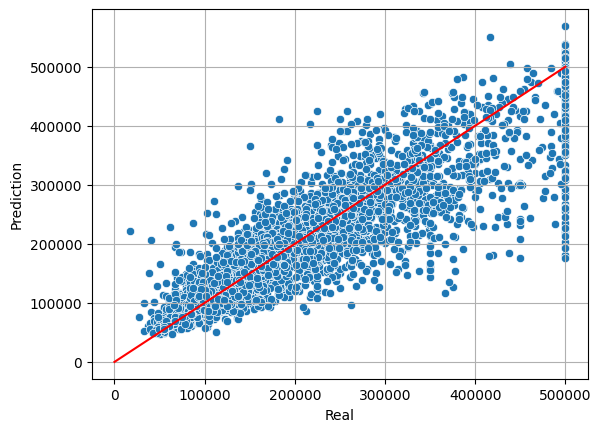

In [32]:
# Métricas del train (por curiosidad)
print('Train ', end='')
regression_report(reg_model, X_train, y_train)

# Métricas sobre test
print('\nTest ', end='')
regression_report(reg_model, X_test, y_test)

# Visualizar la desviación de las predicciones
y_pred = reg_model.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 500_000],[0, 500_000], 'red')
plt.grid()
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.show()

Ahora tocaría analizar estos resultados con "negocio" y determinar si son una predicciones aceptables o no.